> Created on Sat Jun  3 21:56:11 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 3.5-D 马尔可夫随机场（MRF）和城市降温模型的 MRF 推理  

## 3.5.1 无向图模型

### 3.5.1.1 参数化马尔可夫网（Markov Network）

<img src="../imgs/3_5_d/3_5_d_03.png" height='auto' width=200 title="caDesign"> 

如果假设有4个表征土地利用（landuse，LU）类型邻接的栅格单元（如图）$A,B,C,D$作为随机变量，每个变量可能分配的 LU 类型只有两类，住宅和绿地，用数值0和1表示分配的状态。那么，$\{A,B\}$、$\{B,C)\}$、$\{C,D\}$和$\{D,A\}$之间分配的 LU 类型可能的状态为住宅对住宅（0对0）、住宅对绿地（0对1）、绿地对住宅（1对0）和绿地对绿地（1对1）等4种结果，并希望满足$(A \perp C \mid\{B, D\})$和$(B \perp D \mid\{A, C\})$而不包括其它独立性条件的分布进行建模。可以发现该类问题两两随机变量之间存在的边并没有方向，而是对称的，因此构建无向图模型（马尔可夫网（Markov Network，MN）），书写代码绘制节点和边如下。

> 主要参考*Probabilistic Graphical Models : Principles and Techniques*<sup>[1]</sup>，*Mastering Probabilistic Graphical Models Using Python*<sup>[2]</sup>和*Markov Random Field Modeling in Image Analysis*<sup>[3]</sup>及相关文献，及应用[pgmpy](https://github.com/pgmpy/pgmpy)<sup>[4]</sup>库书写本章内容和代码。

In [219]:
%load_ext autoreload 
%autoreload 2 
import warnings
warnings.filterwarnings('ignore')

import usda.pgm as usda_pgm
import usda.data_visual as usda_vis

from pgmpy.models import FactorGraph
from pgmpy.factors.discrete import DiscreteFactor
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


绘制无向图网络。

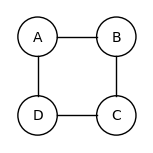

In [61]:
import daft

# Instantiate the PGM.
pgm=daft.PGM(node_unit=1, grid_unit=2, directed=False,dpi=100)

pgm.add_node('A','A',0,1)
pgm.add_node('B','B',1,1)
pgm.add_node('C','C',1,0)
pgm.add_node('D','D',0,0)

pgm.add_edge('A','B')
pgm.add_edge('B','C')
pgm.add_edge('C','D')
pgm.add_edge('D','A')

pgm.render();

以$\{A,B\}$之间的 LU 类型邻接关系为例，如果同为住宅的可能性（30）大于同为绿地的可能性（10），并大于二者为不同类型的可能性。且为不同类型时，$A$为住宅对$B$为绿地的可能性（5）大于$A$为绿地而$B$为住宅的可能性（1）。那么，可以配置$\{A,B\}$邻接关系的概率如下图（使用[pgmpy库](https://github.com/pgmpy/pgmpy)<sup>①</sup>实现，并定义`draw_factor_graph()`方法绘制网络）。将$\{A,B\}$状态关系概率的描述定义为一个具有通用目标的函数（ general-purpose function），这个函数也被称为一个因子（factor）（或称为势函数（potential function）），有如下定义。

定义： 假设$D$表示随机变量的集合，因子$\phi$定义为从$Val(D)$映射到实数域$R$的一个函数。假如因子的所有表值均非负，那么这个因子是非负的（nonnegative），变量集$D$称为因子的**辖域（scope ）**，记为$Scopt[\phi]$。

上述$\{A,B\}$状态概率关系中的因子可以写为$\phi(A, B): \operatorname{Val}(A, B) \mapsto \boldsymbol{R}^{+} $，因子的值`(30,5,1,10)`并没有归一化，且不一定在`[0,1]`之内。

+------+------+------------+
| A    | B    |   phi(A,B) |
+======+======+============+
| A(0) | B(0) |    30.0000 |
+------+------+------------+
| A(0) | B(1) |     5.0000 |
+------+------+------------+
| A(1) | B(0) |     1.0000 |
+------+------+------------+
| A(1) | B(1) |    10.0000 |
+------+------+------------+
True


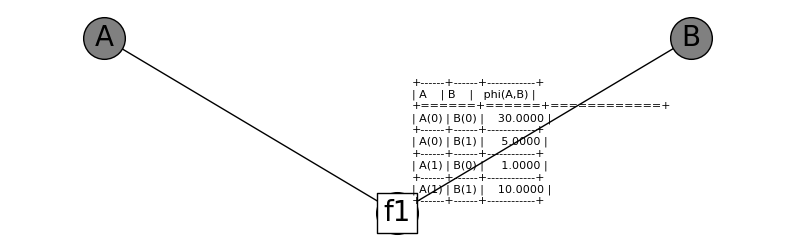

In [62]:
G=FactorGraph()
G.add_nodes_from(['A','B'])
phi=DiscreteFactor(['A','B'],[2,2],[30,5,1,10])
print(phi)
G.add_factors(phi)
G.add_nodes_from([phi])
G.add_edges_from([('A', phi), ('B', phi)])
print(G.check_model())
usda_pgm.draw_factor_graph(G)  

配置随机变量间所有 LU 类型邻接关系的因子，如下代码和打印的因子图，

定义：**因子图** $\mathcal{F}$是包含变量节点（椭圆或圆表示）与因子节点（方形表示）的一个无向图。该图只包含变量节点和因子节点之间的边，并由一系列因子参数化，其中每个因子节点$V_\phi$正好与因子$\phi$相关联，其辖域是图中与$V_\phi$相邻节点的变量集。

因为示例中每个变量（栅格单元）(总共4个变量)有两个状态（住宅0和绿地1），因此连接两个变量的每个因子参数个数为4个，那么图中参数的总数为$4\left(\begin{array}{l}n \\2\end{array}\right)=4 \times 4=16$。

In [220]:
G=FactorGraph()
G.add_nodes_from(['A','B','C','D'])
phi1=DiscreteFactor(['A','B'],[2,2],[30,5,1,10])
phi2=DiscreteFactor(['B','C'],[2,2],[100,1,1,100])
phi3=DiscreteFactor(['C','D'],[2,2],[1,100,100,1])
phi4=DiscreteFactor(['D','A'],[2,2],[100,1,1,100])

G.add_factors(phi1,phi2,phi3,phi4)
G.add_edges_from([('A', phi1), ('A', phi4),
                  ('B', phi1), ('B', phi2),
                  ('C', phi2), ('C', phi3),
                  ('D', phi3), ('D', phi4)])
print(G.check_model())

True


绘制因子图。

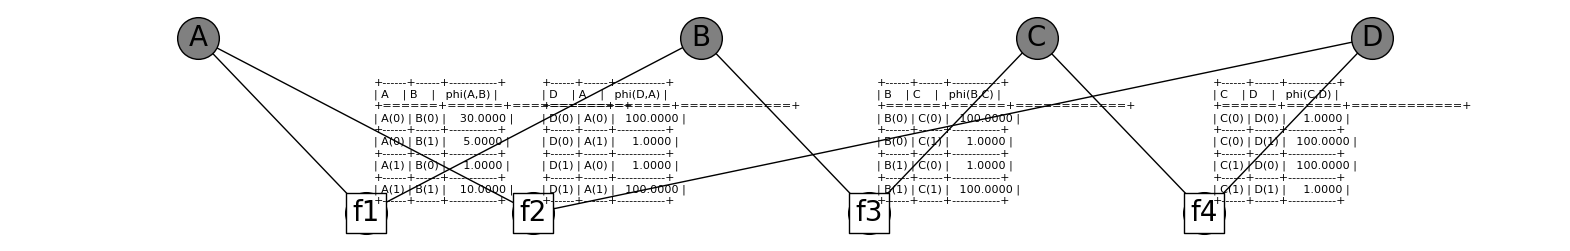

In [64]:
usda_pgm.draw_factor_graph(G,figsize=(20,3))  

通过定义的变量间局部交互影响（局部模型（local model））定义全局模型（global model），以局部模型相乘的方式进行组合。例如，示例中结果`phi(A,B,C,D)`列。

In [221]:
phi=phi1*phi2*phi3*phi4
print(phi)

+------+------+------+------+----------------+
| B    | C    | A    | D    |   phi(B,C,A,D) |
+======+======+======+======+================+
| B(0) | C(0) | A(0) | D(0) |    300000.0000 |
+------+------+------+------+----------------+
| B(0) | C(0) | A(0) | D(1) |    300000.0000 |
+------+------+------+------+----------------+
| B(0) | C(0) | A(1) | D(0) |       100.0000 |
+------+------+------+------+----------------+
| B(0) | C(0) | A(1) | D(1) |   1000000.0000 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(0) | D(0) |    300000.0000 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(0) | D(1) |        30.0000 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(1) | D(0) |       100.0000 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(1) | D(1) |       100.0000 |
+------+------+------+------+----------------+
| B(1) | C(0) | A(0) | D(0) |       500.0000 |
+------+------+------+------+----------------+
| B(1) | C(0)

因为相乘的结果并不能保证是一个归一化的联合概率分布（joint probability distribution，JPD），因此定义，$P(a, b, c, d)=\frac{1}{Z} \phi_1(a, b) \cdot \phi_2(b, c) \cdot \phi_3(c, d) \cdot \phi_4(d, a)$，式中，$Z=\sum_{a, b, c, d} \phi_1(a, b) \cdot \phi_2(b, c) \cdot \phi_3(c, d) \cdot \phi_4(d, a)$。$Z$是一个归一化常数，通常称为配分函数（partition function），“配分（partition）”一词源于马尔可夫网的早期历史，而马尔可夫网则源自统计物理学中的马尔可夫随机场（Markov random field，MRF）。使用“函数”一词则是因为$Z$的值是参数的一个函数。归一化结果如下计算结果`phi(A,B,C,D)`列。

In [222]:
phi.normalize()
print(phi)

+------+------+------+------+----------------+
| B    | C    | A    | D    |   phi(B,C,A,D) |
+======+======+======+======+================+
| B(0) | C(0) | A(0) | D(0) |         0.0417 |
+------+------+------+------+----------------+
| B(0) | C(0) | A(0) | D(1) |         0.0417 |
+------+------+------+------+----------------+
| B(0) | C(0) | A(1) | D(0) |         0.0000 |
+------+------+------+------+----------------+
| B(0) | C(0) | A(1) | D(1) |         0.1389 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(0) | D(0) |         0.0417 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(0) | D(1) |         0.0000 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(1) | D(0) |         0.0000 |
+------+------+------+------+----------------+
| B(0) | C(1) | A(1) | D(1) |         0.0000 |
+------+------+------+------+----------------+
| B(1) | C(0) | A(0) | D(0) |         0.0001 |
+------+------+------+------+----------------+
| B(1) | C(0)

获得 JPD 后，可以用其回答查询，例如栅格单元$B$的 LU 类型为住宅或者为绿地的概率为0.263和0.736。计算的方法给出了两种，一种是用边缘化`marginalize`方法，对归一化的 JPD 操作；另一种是用`VariableElimination`结合`query`方法，将为`pgmpy.models.FactorGraph.FactorGraph`对象的`G`，转化为为`pgmpy.models.MarkovNetwork.MarkovNetwork`对象的`mm`后，对`mm`操作。

In [67]:
B_marginalized=phi.marginalize(['A','C','D'],inplace=False)
print(B_marginalized)

+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.2639 |
+------+----------+
| B(1) |   0.7361 |
+------+----------+


`query`方法查询的结果并没有实现归一化，因此除以配分函数$Z$，计算结果同上。

In [228]:
from pgmpy.inference import VariableElimination,BeliefPropagation
mm=G.to_markov_model()
infer=VariableElimination(mm)
B_prob=infer.query(['B'])
print(B_prob)

Z=G.get_partition_function()
print(Z)
print(B_prob.values/Z)

+------+--------------+
| B    |       phi(B) |
+======+==============+
| B(0) | 1900330.0000 |
+------+--------------+
| B(1) | 5301510.0000 |
+------+--------------+
7201840.0
[0.26386729 0.73613271]


又例如给定证据$C$的状态为住宅时，$B$的概率。计算方法也给出了两种，一种是对 JPD 直接计算，用到了因子约简`reduce`和`marginalize`方法；另一种是用`query`方法。

In [69]:
phi_reduced_C0=phi.reduce([('C',0)],inplace=False)
print(phi_reduced_C0)
B_reduced_marginalized=phi_reduced_C0.marginalize(['A','D'],inplace=False)
print(B_reduced_marginalized)

+------+------+------+--------------+
| D    | B    | A    |   phi(D,B,A) |
+======+======+======+==============+
| D(0) | B(0) | A(0) |       0.0417 |
+------+------+------+--------------+
| D(0) | B(0) | A(1) |       0.0000 |
+------+------+------+--------------+
| D(0) | B(1) | A(0) |       0.0001 |
+------+------+------+--------------+
| D(0) | B(1) | A(1) |       0.0000 |
+------+------+------+--------------+
| D(1) | B(0) | A(0) |       0.0417 |
+------+------+------+--------------+
| D(1) | B(0) | A(1) |       0.1389 |
+------+------+------+--------------+
| D(1) | B(1) | A(0) |       0.0001 |
+------+------+------+--------------+
| D(1) | B(1) | A(1) |       0.0139 |
+------+------+------+--------------+
+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.2222 |
+------+----------+
| B(1) |   0.0140 |
+------+----------+


In [224]:
B_prob_C0=infer.query(['B'],evidence={'C':0})
print(B_prob_C0)
print(B_prob_C0.values/Z)

+------+--------------+
| B    |       phi(B) |
+======+==============+
| B(0) | 1600100.0000 |
+------+--------------+
| B(1) |  101010.0000 |
+------+--------------+
[0.22217933 0.01402558]


### 3.5.1.2 吉布斯分布（Gibbs Distributions）

用因子积的更一般概念来定义一个分布的无向参数化。

定义：假如分布$P_{\Phi}$定义如下：$P_{\Phi}\left(X_1, \cdots, X_n\right)=\frac{1}{Z} \tilde{P}_{\Phi}\left(X_1, \cdots, X_n\right)$，式中，$\tilde{P}_{\Phi}\left(X_1, \cdots, X_n\right)=\phi_1\left(D_1\right) \times \phi_2\left(D_2\right) \times \cdots \times \phi_m\left(D_m\right)$是非归一化的度量，且$Z=\sum_{X_1.  \cdots. X_n} \tilde{P}_{\Phi}\left(X_1, \cdots, X_n\right)$为称为配分函数的归一化常数，那么分布$P_{\Phi}$称为由因子集$ \Phi=\left\{\phi_1\left(D_1\right), \cdots, \phi_\kappa\left(D_\kappa\right)\right.\}$参数化的吉布斯分布（Gibbs Distributions）。

如果仅考虑$\{A,B\}$的局部因子$\phi_1(a,b)$可以得知$\phi_1(a^0,b^0)$为最大值，即变量$A$和$B$同为住宅的可能性最大。但是观察基于吉布斯分布（总体分布）上的$\{A,B\}$关系可以发现$\phi_1(a^0,b^1)$，即$A$为住宅而$B$为绿地状态关系的可能性最大。造成这种不一致的原因来自于其它因子对分布的影响，可以发现，$\phi_3(C,D)$中$C$和$D$ LU 类型不一致的可能性最大，而$\phi_3(B,C)$和$\phi_4(D,A)$则表明对应变量 LU 类型一致的可能性最大，因此可以推测$A$和$B$ LU 类型不一致的可能性趋大。由于其它因子的影响值为100，而$\{A,B\}$局部因子为30，以至于其它因子的影响淹没了局部因子状态关系的概率。

In [71]:
print(infer.query(['A','B']))
print(infer.query(['A','B']).values/Z)

+------+------+--------------+
| A    | B    |     phi(A,B) |
+======+======+==============+
| A(0) | B(0) |  900030.0000 |
+------+------+--------------+
| A(0) | B(1) | 5001500.0000 |
+------+------+--------------+
| A(1) | B(0) | 1000300.0000 |
+------+------+--------------+
| A(1) | B(1) |  300010.0000 |
+------+------+--------------+
[[0.12497223 0.6944753 ]
 [0.13889506 0.04165741]]


再将吉布斯分布的参数化与图的结构联系起来时，定义有，假设每个$\boldsymbol{D}_k(k=1, \cdots, K)$都是$\mathcal{H}$的完全子图（complete subgraph），则称具有$\Phi=\left\{\phi_1\left(D_1\right), \cdots, \phi_k\left(D_k\right)\right\}$的分布$ P_{\Phi}$在马尔可夫网$\mathcal{H}$上因子分解。

参数化马尔可夫网的因子通常称为**团位势（clique potentials）**。

> 团（Clique）是无向图中顶点的子集，满足每两个不同的顶点都是相邻的，其子图为完全图（complete graph）。可查看*图属性的基本度量*章节。

由于每个完全子图都是某些（最大）团的子集，因此可以通过只允许对最大团设定因子的方式来减少因子的数量。令$\boldsymbol{C}_1, \cdots, \boldsymbol{C}_k$为$\mathcal{H}$中的团，可以利用一系列因子$\phi_1\left(\boldsymbol{C}_1\right), \cdots, \phi_l\left(\boldsymbol{C}_l\right)$来参数化$P$。通过简单的将每个因子指定给覆盖其辖域的一个团，并将指定给每个团的所有因子相乘，以这种生成团位势方式，任何根据完全子图的因子分解都可以转化为这一形式。在上述马尔可夫网示例中，包含有4个团，为$\{A,B\}\{B,C\}\{C,D\}\{D,A\}$。

### 3.5.1.3 对数线性模型

定义因子（势函数）时，并没有将因子限制为特定的概率分布，因此可以定义任意因子，但仍然需要满足$\phi(D) \geq 0$，保证$P(X) \geq 0$。通常$\phi(D)$可以改写为，$\phi(\boldsymbol{D})=\exp (-\epsilon(\boldsymbol{D}))$，式中，$\epsilon(D)=-\ln \phi(D)$通常叫做**能量函数**。"能量"一词来自于统计物理，其中物理状态的概率（如一系列电子的构型（conﬁguration））反比于其能量，即能量值越大，当前状态越不稳定；能量值越小，当前状态越趋于稳定。在这个对数化的表示中，有$P\left(X_1, \cdots, X_n\right) \propto \exp \left[-\sum_{i=1}^m \epsilon_i\left(\boldsymbol{D}_i\right)\right]$。这种对数表示可以保证概率分布式正的，且对数的参数可以沿着实数轴任意取值。

打印能量函数曲线，观察数值分布和变化趋势。

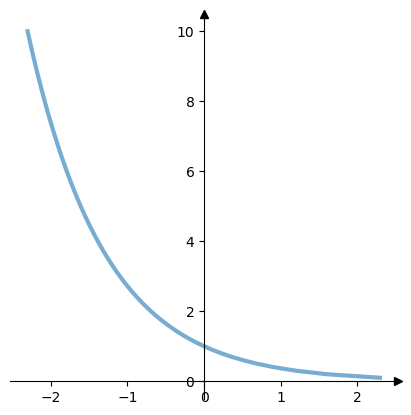

In [6]:
fig, ax=plt.subplots(1, 1,figsize=(5,5))
phi = np.linspace(0, 10, 100)
ax.plot(-np.log(phi),phi, lw=3, alpha=0.6)

usda_vis.plot_style_axis_A(ax)
plt.show()

计算示例团位势参数的对数表示，可以看到团位势中的表值1在能量函数中转化成立0，即两个变量的取值一致时，该能量函数的值为1；当两个变量的取值不一致时，该能量函数的值为0。

In [134]:
for f in G.get_factor_nodes():
    print(f'{set(f.state_names.keys())}:\n{-np.log(f.values)}')

{'D', 'A'}:
[[-4.60517019 -0.        ]
 [-0.         -4.60517019]]
{'D', 'C'}:
[[-0.         -4.60517019]
 [-4.60517019 -0.        ]]
{'B', 'C'}:
[[-4.60517019 -0.        ]
 [-0.         -4.60517019]]
{'B', 'A'}:
[[-3.40119738 -1.60943791]
 [-0.         -2.30258509]]


定义，令$\boldsymbol{D}$是变量的一个子集，**特征**$f(\boldsymbol{D})$定义为从$\operatorname{Val}(\boldsymbol{D})$到$\boldsymbol{R}$的一个函数。简单来说，特征是没有非负要求的一个因子。其中特别的一类特征是**指示特征（indicator feature）**，该特征对某些值$y \in \operatorname{Val}(\boldsymbol{D})$取值为1，而对其它一些值取值为0。特征为更紧凑具体指明某些类型的交互影响提供了简单的机制。例如，考虑变量$A_1$和$A_2$都有$\ell$个值$a^1, \ldots, a^{\ell}$的情形。假定分布倾向于$A_1$和$A_2$取相同的值，除此之外则没有任何倾向。因此能量函数的形式可以定义为，$\epsilon\left(A_1, A_2\right)=\left\{\begin{array}{cc}-3, & A_1=A_2 \\0, & \text { otherwise}\end{array}\right. $。对于特征$f\left(A_1, A_2\right)$也可以表示为对数线性函数，，其中$f\left(A_1, A_2\right)$是事件$A_1= A_2$的**示性函数（indicator function）**。这样，能量函数可以简单的表示为这个特征的-3倍。

因此，对于对数线性模型，可以定义为：假如分布$P$与下述条件相关，

* 特征集$\mathcal{F}=\left\{f_1\left(\boldsymbol{D}_1\right), \cdots, f_k\left(\boldsymbol{D}_k\right)\right\}$，式中，每个$\boldsymbol{D}_i$是$ \mathrm{H}$中的一个完全子图，

* 一系列权重$\omega_1, \cdots, \omega_k$

并且使得$P\left(X_1, \cdots, X_n\right)=\frac{1}{Z} \exp \left[-\sum_{i=1}^k \omega_i f_i\left(D_i\right)\right]$，那么，分布$P$是马尔可夫网$\mathcal{H}$上的一个**对数线性模型（log-linear model）**。

### 3.5.1.4 独立性与马尔可夫毯（Markov blanket）

* 独立性

马尔可夫网中的图结构可以看作是对一系列独立性假设的编码，其中概率影响在图中沿无向路径“流动”，但当对某些中间节点取条件时，“流动”会受到阻碍。

定义， 令$\mathcal{H}$表示一个马尔可夫网结构，$X_1-\cdots-X_k$ 是$\mathcal{H}$中的一条路径。令$\mathbf{Z} \subseteq \mathcal{X}$是观察变量的一个集合，如果所有$X_i(i=1, \cdots, k)$的节点均不在$Z$中，则路径$X_1-\cdots-X_k$在给定$Z$时是有效路径。

基于上述定义，定义分离（separation）的概念。

定义，如果给定$Z$时，任意两个节点$X \in \boldsymbol{X}$和$Y \in \boldsymbol{Y}$之间没有路径，那么称节点集$Z$在$\mathcal{H}$中分离$\boldsymbol{X}$和$\boldsymbol{Y}$，记为$\operatorname{sep}_\mathcal{H}(\boldsymbol{X} ; \boldsymbol{Y} \mid \boldsymbol{Z})$，与$\mathcal{H}$关联的全局独立性定义为：$\mathcal{I}(\mathcal{H})=\left\{(\boldsymbol{X} \perp \boldsymbol{Y} \mid \boldsymbol{Z}): \operatorname{sep}_{\mathcal{H}}(\boldsymbol{X} ; \boldsymbol{Y} \mid \boldsymbol{Z})\right\}$。注意，分离的定义在$Z$中时单调的（monotonic），如果有$\operatorname{sep}_\mathcal{H}(\boldsymbol{X} ; \boldsymbol{Y} \mid \boldsymbol{Z})$，则对任意$Z^{\prime} \supset Z$都具有$\operatorname{sep}_{\mathcal{H}}\left(\boldsymbol{X} ; \boldsymbol{Y} \mid \boldsymbol{Z}^{\prime}\right)$。

`get_local_independencies`方法返回马尔可夫模型中存在的所有局部独立性。

In [ ]:
print(mm.get_local_independencies())

(A ⟂ C | D, B)
(D ⟂ B | A, C)
(B ⟂ D | A, C)
(C ⟂ A | D, B)
['B', 'D']


* 马尔可夫毯（Markov blanket）与局部马尔可夫假设

只要两个变量直接相连，它们就有可能无需其它变量调节而直接相关。相反，如果两个变量没有直接连接，必定存在某种方式使它们条件独立。

定义，令$\mathcal{H}$为一个马尔可夫网。与$\mathcal{H}$相关的成对独立性定义如下：$\mathcal{I}_p(\mathcal{H})=\{(X \perp Y \mid \mathcal{X}-\{X, Y\}): X-Y \notin \mathcal{H}\}$。

通过对节点的直接近邻节点取条件来阻止在该节点上的所有影响。

定义，对于给定的图$\mathcal{H}$，$X$在$\mathcal{H}$中的马尔可夫毯$MB_\mathcal{H}(X)$定义为$X$在$\mathcal{H}$中的近邻。与$\mathcal{H}$相关的局部独立性定义为：$\mathcal{I}_l(\mathcal{H})=\left\{\left(X \perp \mathcal{X}-\{X\}-\operatorname{MB}_{\mathcal{H}}(X) \mid \operatorname{MB}_{\mathcal{H}}(X)\right): X \in \mathcal{X}\right\}$。该局部独立性表明，在给定其直接近邻后，$X$与图中的其它节点独立。可以证明这些局部独立性假设对于在$\mathcal{H}$上因子分解的任何分布均成立，从而使得$X$在$\mathcal{H}$中的马尔可夫毯确实可以将其从图中的其它变量中分离出来。

`markov_blanket`方法可以返回给定随机变量的马尔可夫毯（给定节点的相邻节点）。

In [24]:
for X in phi.variables:
    print(f'{X}-->{list(mm.markov_blanket(X))}')

C-->['B', 'D']
D-->['C', 'A']
B-->['A', 'C']
A-->['B', 'D']


对于$n \times n$大小的栅格数据$\mathcal{S}=\{(i, j) \mid 1 \leq i, j \leq n\}$，其一阶邻域系统（ﬁrst-order neighborhood system），也称为4（点）邻域系统（4-neighborhood system），例如对栅格单元$X_{(2,2)}$而言，包括$X_{(2,1)},X_{(2,3)},X_{(1,2)},X_{(3,2)}$等4个单元，即$\mathcal{N}_{i, j}=\{(i-1, j),(i+1, j),(i, j-1),(i, j+1)\}$；其二阶邻域系统（second-order neighborhood system），也称为8（点）邻域系统（8-neighborhood system），例如对栅格单元$X_{(2,2)}$而言，其近邻栅格单元为图中标识为灰色的8个单元，即$\mathcal{N}_{i, j}=\{(i-1, j),(i+1, j),(i, j-1),(i, j+1),(i-1,j+1),(i-1,j-1),(i+1,j+1),(i+1,j-1)\}$；n-阶邻域系统（nth-order neighborhood system）是沿观测栅格单元不断向外扩展的一个过程。对于$\mathcal{S}$的四角和四边上的单元对应4或8邻域系统其近邻单元数会相应减少，例如4邻域系统，其四角近邻单元有两个，而四边上的有3个<sup>[3]22</sup>。

当将图像建模为马尔可夫随机场（Markov random field，MRF）时，邻域系统的每个栅格单元都可以从其它单元访问。图右侧给出了与其相关不同大小的团。

<img src="../imgs/3_5_d/3_5_d_04.png" height='auto' width=800 title="caDesign"> 

## 3.5.2 计算机视觉中的马尔可夫网

马尔可夫网的一个重要应用领域是计算机视觉。马尔可夫网在计算机视觉领域通常称为马尔可夫随机场（Markov random field，MRF），广泛应用于多种视觉处理任务中，例如图像分割、去模糊和去噪、三维重建、物体识别等。一般网络以 MRF 形式呈现时，其中变量对应于像素（用于地理信息系统时，为栅格单元），而边（因子）对应于表示图像网络上相邻像素之间的交互影响。按4（如下图）或8邻域系统，每个像素有4个或8个近邻节点。变量的取值空间和因子的确切形式取决于所要处理的任务。这些模型通常用能量（负对数位势）（ energies (negative log-potentials)）来明确表达，从前文能量函数曲线（翻转x和y轴）可以观察到，随值的增加曲线快速下降并趋于平缓，表征了对变化值的“惩罚（penalties）”，且一个较小的值对应着一个高概率的结构。


In [1]:
%load_ext autoreload 
%autoreload 2 
import warnings
warnings.filterwarnings('ignore')

import usda.pgm as usda_pgm
import usda.data_visual as usda_vis
import usda.imgs_process as usda_imgprocess

import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

定义在图$\mathcal{H}$上的一个成对 MRF（如下图） 与一个节点位势集$\left\{\phi\left(X_i\right): i=1, \cdots, n\right\}$和一个边位势集$\left\{\phi\left(X_i, X_j\right):\left(X_i, X_j\right) \in \mathcal{H}\right\}$相关，总体分布是所有这些位势（包括节点和边）的归一化乘积。

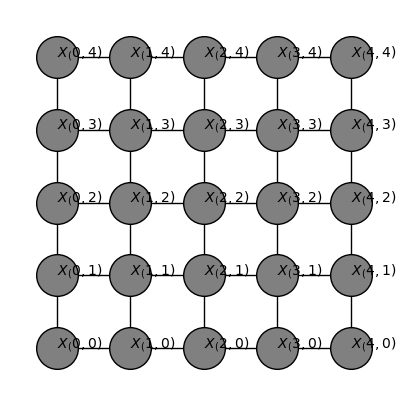

In [134]:
usda_pgm.draw_grid_graph(5,5)  

* Ising 模型
    
Ising 是最早的马尔可夫网之一，在统计物理中提出，作为一个包含原子相互作用物理系统的能量模型。在这些系统中，每个原子与一个二值的随机变量$X_i \in\{+1,-1\}$关联，其值定义了原子旋转的方向。与边关联的能量函数（边位势）可以定义为$\epsilon_{i, j}\left(x_i, x_j\right)=-\omega_{i, j} x_i x_j$，式中$\omega_{i, j}$为超参数（边位势权重），可以发现，当$X_i=X_j$（两个原子具有相同的旋转方向）时，能量函数结果为$\omega_{i, j}$；否则，其结果为$-\omega_{i, j}$。Ising 模型同时还包含一系列编码单个节点位势的参数$u_i$，这些参数在个体变量选择旋转时产生影响。综合边位势和节点位势，该能量函数定义的分布为$P(\xi)=\frac{1}{Z} \exp \left(-\sum_{i<j} \omega_{i, j} x_i x_j-\sum_i u_i x_i\right)$。

当$\omega_{i, j}>0$时，该模型倾向于两个原子的旋转相一致，称为铁磁的（ferromagnetic）；如果当$\omega_{i, j}<0$，则称为反铁磁的（antiferromagnetic）；如果当$\omega_{i, j}=0$，表示原子之间无交互作用（non-interacting）。
    
* 度量 MRF
    
一类重要的 MRF 是由用于分类的随机场组成。假如存在边集$\mathcal{E} $相连的节点$X_1, \cdots, X_n$的一个图，期望对每个节点$X_i$指定空间$\mathcal{V}=\left\{v_1, \cdots, v_\kappa\right\}$中的一个标签。每个单独考虑的节点在所有可能的标签中都有其自己的偏好；且由于邻近节点应该取“相似”的值，所以还希望在图上施以一个“平滑”约束。

对于单个节点的偏好可以编码为成对 MRF 中的节点位势；而平滑偏好则可以编码为边位势。这些模型可以在负对数空间中用能量函数表示，且必然是以最大化后验概率为目标，因此可以忽略掉配分函数，只简单考虑能量函数为$E\left(x_1, \cdots, x_n\right)=\sum_i \epsilon_i\left(x_i\right)+\sum_{(i, j) \in \epsilon} \epsilon_{i, j}\left(x_i, x_j\right)$，于是，目标是最小化如下能量$\arg \min _{x_1, \cdots, x_n} E\left(x_1, \cdots, x_n\right)$。

* 截断范数（truncated norm）

对每个像素$X_i$都有一个节点位势，用来惩罚与观测到的像素值$y_i$之间的差异；边位势编码了相邻像素之间连续性的偏好，用来惩罚相邻节点$X_i$和$X_j$之间推测值相差太大的情况。然而为了避免与真实情况不一致的过度惩罚，例如物体或区域之间的边缘，通常需要为惩罚项限定一个界限，即为截断范数，公式为$\left.\epsilon\left(x_i, x_j\right)=\min \left(c\left\|x_i-x_j\right\|_p \text {, } \text { dist }_{\text {max }}\right) \text { (for } p \in\{1,2\}\right)$。

### 3.5.2.1 二值型随机变量的 MRF 建模（Ising  模型）——以图像降噪为例<sup>[5]</sup>
    
二值型图像降噪 MRF 模型构建，依据 Ising 模型的能量函数，4-邻域系统的边位势代码可书写为，
    
```python
patch = 0
for k in range(-1,1):
    for l in range(-1,1):
        patch += J[i,j] * J[i+k,j+l]
```

为栅格单元（像素）与其4个邻近栅格单元的乘积和，其中`i,j`为当前栅格单元索引。节点位势为`np.sum(I*J)`，变量`I`为目标栅格，即各随机变量的最终状态取值，这里直接使用了没有噪声的原始图像；变量$J$为噪声图像。综合边位势和节点位势，最终的能量函数对应代码可书写为`energya = -eta*np.sum(I*J) - zeta*patch`，其中`eta`和`zeta`为超参数，对应为节点位势权重和边位势权重。因为只有两个取值，因此可以分别计算每个节点重新赋值为1或-1时的能量函数，最后比较这两种情况的结果，取最小能量对应的状态值作为该节点随机变量的最终状态值。
    
使用 Ising 模型处理二值图像降噪问题结果如下，可以说明最小化包含边位势和顶点位势能量函数的 MRF 模型处理相关二维空间问题是可行的。

In [10]:
img_fn=r'C:\Users\richi\omen_richiebao\omen_github\USDA_special_study\imgs\3_5_d\3_5_d_06.png'    
img_original_mono,img_noise=usda_imgprocess.binarize_noise_image(img_fn,resize=(256,256))   
denoised_img=usda_pgm.MRF_binary(img_original_mono,img_noise)

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:15<00:00, 16.15it/s]


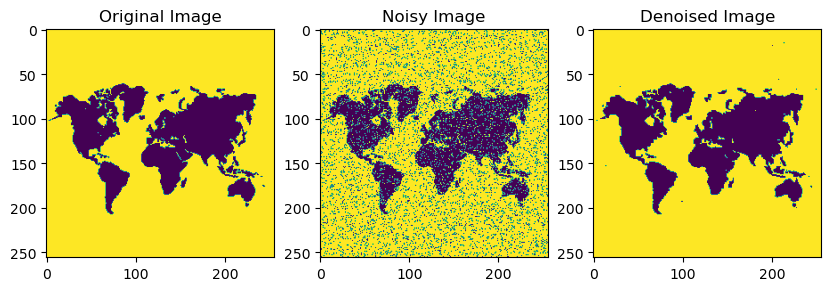

In [252]:
fig, axes=plt.subplots(1, 3,figsize=(10,5))
axes[0].imshow(img_original_mono)
axes[1].imshow(img_noise)
axes[2].imshow(denoised_img)

axes[0].set_title('Original Image')
axes[1].set_title('Noisy Image')
axes[2].set_title('Denoised Image')

plt.show()

### 3.5.2.2 离散型随机变量（多分类）的 MRF 建模——以图像分割为例<sup>[6]</sup>

在多类别分割的表示中，每个变量$X_i$有一个域（domain），其中$X_i$的值表示像素$i$的一个区域分配，例如 LULC 中的建筑、草地、林地和水体等。为了减小分类每个栅格单元的计算量，可以先将图像分割成一些超级像素（superpixels）（连续的小区域），然后对这些区域进行分类，每个区域中的所有栅格单元类别完全一致。这个过渡分割的图像可以导出一个图，其中每个节点代表一个超级像素，并且当两个超级像素在对应的原始栅格图像中彼此相邻时，使得两个超级像素节点间存在一个边。

可以在图像中为每个栅格单元（像素）或者超级像素提取特征，特征的形式取决于具体的任务。例如图像分割时，可以先聚类 RGB 颜色值（通道或波段），如下述计算结果图左`clustering`；也可以将其输入到局部分类器中分类。之后将上述结果，即栅格单元或超级像素的软聚类（soft cluster ）或局部分类用于模型的特征输入。每个栅格单元或超级像素的节点位势是这些特征的一个函数。对应示例中的代码为`closeness=np.linalg.norm(locav[i,j,:,pix_lev]-obs[i,j,:])`，其中`locav`为对应分类（软聚类标签）原始栅格数据（或图像）卷积后的值，用`SciPy`库的`signal.fftconvolve`计算；`obs`为原始栅格数据。对应索引$i,j$栅格单元变量节点$X_{i,j}$的节点位势为对应软聚类卷积值与原始栅格数据差的一个 L2 范数（2-norm）（对向量而言），用`NumPy`库的`linalg.norm`方法实现。

模型在每个相邻的栅格单元或超级像素$X_i$和$X_j$之间包含一个边位势，示例中使用了8-邻域系统，通过判断目标栅格单元和近邻栅格单元是否为同一分类来刻画邻接偏好，例如如果目标单元和邻接单元为同一 LULC 类型则赋值为-1，否则为1，然后计算与所有邻域邻接单元比较结果的和。不难看出，值越大表示目标单元与邻域单元更偏向于为不同分类；值越小则表示为偏向于为同一个分类。在边位势函数的构建上，可以根据不同的任务提出不同的编码，例如目标单元如果为林地，那么邻接单元为草地的可能性会更大些，而同为林地的可能性会小些，这尤其适用于基于超级像素的模型构建。

确定节点位势和边位势后，可得能量函数为`self.beta*cl+closeness/self.std**2`，其中`cl`为顶点位势，`closeness`为边位势；`beta`和`std`为权重参数。

为了避免尺度影响，示例中循环递减卷积核大小进行多次迭代计算，使用了64、32、16和8不同大小的卷积核。

由下述计算结果可以发现，通过 MRF 分割后的分类`segmentaton`比单纯的聚类`clustering`结果分类区域更完整，避免了“椒盐”现象。

In [16]:
img_fn=r'C:\Users\richi\omen_richiebao\omen_github\USDA_special_study\imgs\3_5_d\3_5_d_01.jpg'
seg=usda_pgm.Image_segmentation_using_MRF(img_fn,nlevels=7,win_dim=64,imshow=False)

64
32
16
8


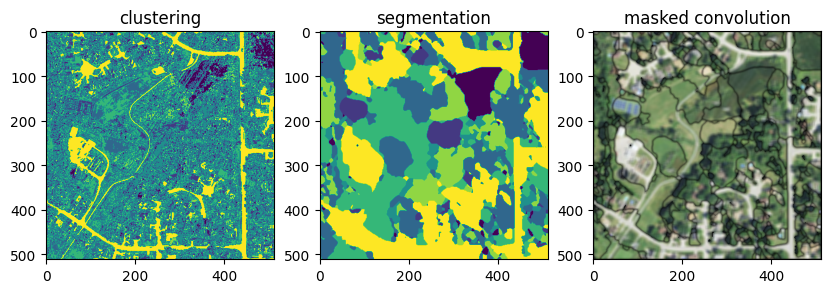

In [21]:
fig, axes=plt.subplots(1, 3,figsize=(10,5))
out=seg.ACAreconstruction(seg.lev,seg.locav)

axes[0].imshow(seg.original_lev)
axes[1].imshow(seg.lev)
axes[2].imshow(out/np.max(out))

axes[0].set_title('clustering')
axes[1].set_title('segmentation')
axes[2].set_title('masked convolution')

plt.show()

### 3.5.2.3 连续型随机变量的 MRF 建模——以图像降噪为例<sup>[7]</sup>

二值型随机变量的 MRF 建模部分是将没有噪点的原始图像输入作为变量的特征向量来解释较为简单的 Ising 模型；图像分割的示例中，是以聚类的结果作为特征向量输入，然后最小后能量函数更新特征向量获得分割区域。在此次示例中，初始化一个值均为0的特征向量（即随机变量的状态值）`X`，对应示例代码`X = torch.zeros_like(noisy).cuda()`；定义能量函数为$f(x, y) = \sum_{i} [ a(x_i-y_i)^2 + \sum_{n=1}^{4} g(x_i-x_{i_n})]$，式中，第1项为节点位势；第2项为边位势。节点位势中，$x_i$为噪声图像栅格单元值，$y_i$为不断更新的特征向量$X$的栅格单元值。在边位势中，$x_i$为特征向量的当前目标栅格单元值，$x_{i_n}$为其4-邻域系统的邻接特征向量的栅格单元值。$a,g$为对应位势权重。将能量函数视为深度学习中的损失函数，应用梯度下降法，通过最小化损失函数优化特征向量。示例中的优化函数选择了`RMSprop`算法，由`PyTorh`库的`torch.optim.RMSprop`方法实现。

从计算结果来看，相对均方根误差(Relative Root Mean Squared Error，RRMSE)能够稳定逐步下降，并趋于平滑。降噪结果虽然没有达到原始无噪声图像的效果，但是对噪声图像有一定的缓和。

> 示例图像，使用了[Image Creator](https://www.bing.com/images/create)<sup>②</sup>生成的伪遥感图像，提示词（prompt）为`High resolution remote sensing satellite imagery with buildings and forests`。

In [23]:
original_img_fn=r'C:\Users\richi\omen_richiebao\omen_github\USDA_special_study\imgs\3_5_d\3_5_d_05.jpg'
noisy_img_fn=r'C:\Users\richi\omen_richiebao\omen_github\USDA_special_study\imgs\3_5_d\3_5_d_05_noise.jpg'

import random
im = Image.open(original_img_fn)
for i in range( round(im.size[0]*im.size[1]/10) ):
      im.putpixel(
        (random.randint(0, im.size[0]-1), random.randint(0, im.size[1]-1)),
        (random.randint(0,255),random.randint(0,255),random.randint(0,255))
      )
im.save(noisy_img_fn)

In [30]:
mrf_c=usda_pgm.MRF_continuous(noisy_img_fn,original_img_fn=original_img_fn,cuda=True,epochs=100,alpha=0.3)   
mrf_c.train()

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 103.43it/s]


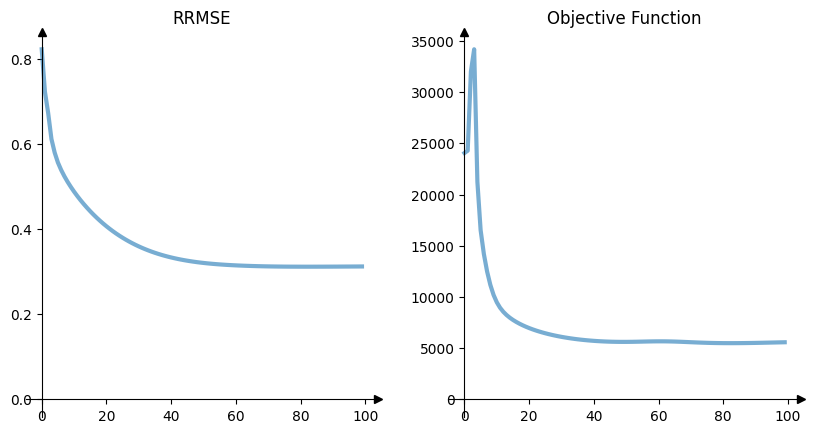

In [31]:
fig, axes=plt.subplots(1, 2,figsize=(10,5))

errors_detach=[i.detach().cpu().numpy() for i in mrf_c.errors]
axes[0].plot(np.arange(0,len(errors_detach)),errors_detach, lw=3, alpha=0.6)
axes[1].plot(np.arange(0,len(mrf_c.losses)),mrf_c.losses, lw=3, alpha=0.6)

axes[0].set_title('RRMSE')
axes[1].set_title('Objective Function')

usda_vis.plot_style_axis_A(axes[0])
usda_vis.plot_style_axis_A(axes[1])
plt.show()

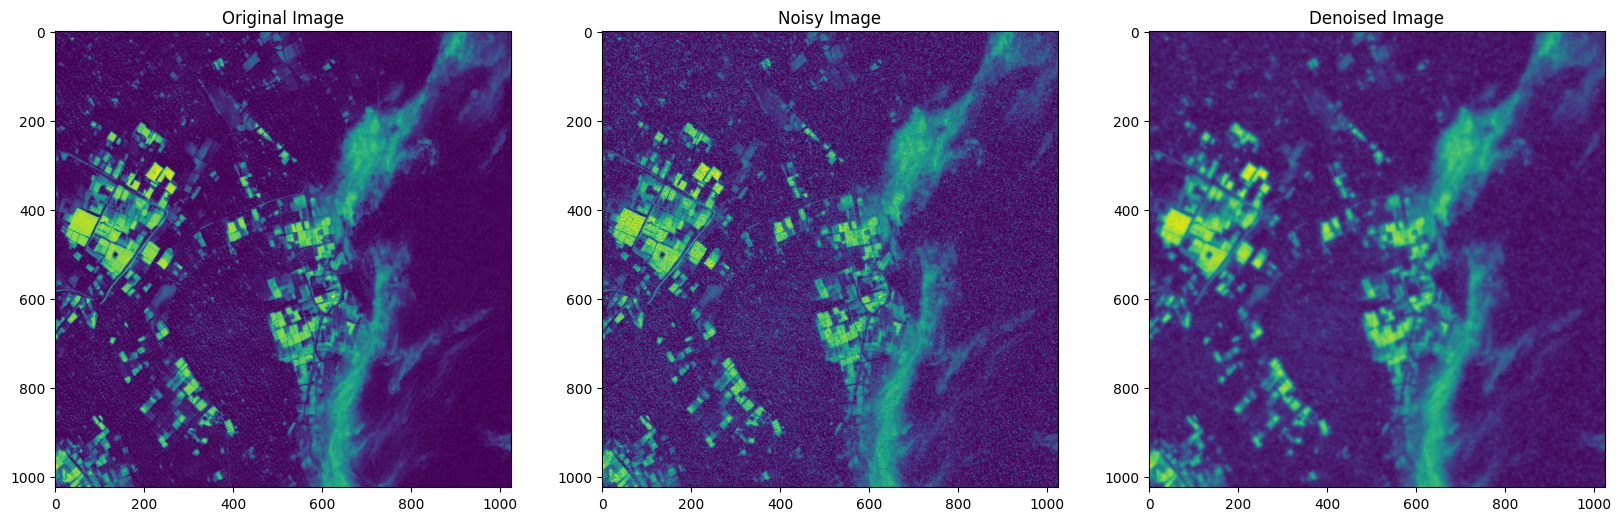

In [32]:
fig, axes=plt.subplots(1, 3,figsize=(20,10))
axes[0].imshow(mrf_c.original_img.cpu())
axes[1].imshow(mrf_c.noisy.cpu())
axes[2].imshow(mrf_c.images[-1])

axes[0].set_title('Original Image')
axes[1].set_title('Noisy Image')
axes[2].set_title('Denoised Image')
plt.show()

## 3.5.3 城市降温模型（InVEST）与 MRF 估计 LULC 类型转换对降温的作用

### 3.5.3.1 城市降温模型

InVEST 提供有[城市降温模型（Urban Cooling Model）](https://storage.googleapis.com/releases.naturalcapitalproject.org/invest-userguide/latest/en/urban_cooling_model.html)<sup>③</sup>，涉及的因子有局部遮荫（local shade）、蒸散（evapotranspiration）、反照率（albedo）和大型绿地（$> 2 ha$）对周边区域的降温效应（cooling effect of large green spaces）等。其中前三项的指数权重和为制冷（Cooling Capacity，CC）指数；如果考虑大型绿地的降温效应，提出城市热缓解（Heat Mitigation，HM）指数。如果栅格单元不受任何大片绿地的影响，HM 等于CC，否则设置为大片绿地和感兴趣栅格单元之间 CC 值的距离加权平均值<sup>[8,9]</sup>。

遮荫指数（shade factor）为与每一 LULC 类别相关的树冠覆盖比例（树木高度 $ \geq 2 m$）。值域为0和1之间。

蒸散指数（evapotranspiration index，ETI）为潜在蒸散的一个标准化值，例如，来自植被的蒸腾或无植被区域土壤的蒸发，其计算公式为$ETI = \frac{K_c \cdot ETo}{ET_{max}}$，式中，$ETo$为用户指定的参照蒸散值；$K_c $为每一栅格单元 LULC 类型相关的作物系数（crop coefficient）；$ET_{max}$为感兴趣区域（area of interest，AOI）$ETo$栅格的最大值。

反照系数（ albedo factor）为太阳辐射被 LULC 类型反射的比例，值域为0和1之间<sup>[10]</sup>。

综合上述3个因子，CC 指数为其权重和，单个栅格单元计算公式为$CC_i = 0.6 \cdot shade + 0.2\cdot albedo + 0.2\cdot ETI$，式中给出的权重值$(0.6,0.2,0.2)$为基于经验数据的推荐值。同时，因为建筑物白天储存热量，而夜间释放热量，因此为了预测夜间温度，一般增加建筑强度（building intensity）因子。

计算 HM 指数，首先需要计算从每一栅格单元$GA_i$到给定具有降温效应距离$d_{cool}$内所有绿地的面积，公式为${GA}_{i}=cell_{area}\cdot\sum_{j\in\ d\ radius\ from\ i} g_{j}$，式中，$cell_{area}$为栅格单元面积（ha），$g_{j}$表示距离$d_{cool}$内搜索的栅格单元是否为绿地，如果是为1，否则为0；并计算每一个绿地公园的 CC 值，公式为$CC_{park_i}=\sum_{j\in\ d\ radius\ from\ i} g_j \cdot CC_j \cdot e^{\left( \frac{-d(i,j)}{d_{cool}} \right)}$，式中，$d(i,j)$为栅格单元$i$和栅格单元$j$之间的距离，$CC_{park_i}$为绿地 CC 值的距离加权均值。然后计算 HM，公式为$H M_i=\left\{\begin{array}{ccc} C C_i & \text { if } & C C_i \geq C C_{\text {park }_i} \text { or } G A_i<2 h a \\ C C_{\text {park }_i} & \text { otherwise } \end{array}\right\}$

* 空气温度估计

城市降温模型为了估计整个城市的热量减少，使用了（地表）城市热岛（surface urban heat islands，SUHI）指数，例如耶鲁大学（University of Yale）开发的[全球地表热岛探测器（Global Surface UHI Explorer）](https://yceo.users.earthengine.app/view/uhimap)<sup>④</sup>提供了年度、季节、白天和夜间热岛的估计数据。没有空气混合的空气温度估计公式为$T_{air_{nomix},i}=T_{air,ref} + (1-HM_i)\cdot UHI_{max}$，式中，$T_{air,ref}$为乡村参考温度，$UHI_{max}$为城市热岛效应的最大值（为观测到的城市最高温度与乡村参考温度的差值）。由于空气混合，这些温度在空间上是平均的。实际上空气温度（混合）$T_{air}$使用给定核大小$r$的高斯函数平滑$T_{air_{nomix}}$。

关于城市降温服务价值计算可直接查看 [InVEST 城市降温模型](https://storage.googleapis.com/releases.naturalcapitalproject.org/invest-userguide/latest/en/urban_cooling_model.html)<sup>③</sup>中的详细解释。对于 InVEST 的城市降温模型，Zawadzka 等人<sup>[11]</sup>通过线性回归将模型计算结果与地表温度（land surface temperature，LST）数据进行比较，验证了三种不同城市形态的 HM 指数，得出 HM 指数和 LST 在 30m 高分分辨率下的相关性高于 2m 高空分辨率，且为强相关。平均而言，HM 指数的0.1变化与 LST 的0.76 $^\circ C$变化相关。因此，该模型更适用于考虑蓝绿空间的城市尺度规划来缓解城市热岛效应达到降温的作用，而不是城市设计的微更新。

InVEST 模型提供了 [Python库版本](https://invest.readthedocs.io/en/latest/index.html)<sup>⑤</sup>，可以通过`pip install natcap.invest`安装后调用。这里则将城市降温模型迁至`USDA`库调用。

In [1]:
%load_ext autoreload 
%autoreload 2 
import warnings
warnings.filterwarnings('ignore')

import usda.pgm as usda_pgm
import usda.data_visual as usda_vis
import usda.migrated_project.invest as usda_esv

import os
import rioxarray as rxr
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import mapclassify
import geopandas as gpd

from tqdm import tqdm
import torch
from torch.optim import RMSprop
from torchvision.transforms import ToTensor

配置模型参数。

In [35]:
data_root=r'I:\data\InVEST_UrbanCoolingModel'
args={
    "aoi_vector_path": os.path.join(data_root,"aoi.shp"), # 最终统计区域
    "avg_rel_humidity": 30, # 平均相对湿度
    "biophysical_table_path": os.path.join(data_root,"Biophysical_UHI_fake.csv"), # 生物物理表 （Biophysical Table ）
    "building_vector_path": os.path.join(data_root,"sample_buildings.shp"), # 建筑轮廓（已建）
    "cc_method": "factors", # CC 指数计算方式。可选'intensity'和'factors'。如果为"factors"，需要配置shade，eti和albedo权重；如果为'intensity'，需要增加配置生物物理表含"building_intensity" 列。
    "cc_weight_albedo": 0.2, # 反照系数 albedo 权重
    "cc_weight_eti": 0.2, # 蒸散指数 eti 权重
    "cc_weight_shade": 0.6, # 遮荫指数 shade 权重
    "do_energy_valuation": True, # 运行节能评估（Energy Savings Valuation）
    "do_productivity_valuation": True, # 运行工作生产力评估（Work Productivity Valuation）
    "energy_consumption_table_path": os.path.join(data_root,"Fake_energy_savings.csv"), # 能源消耗表（Energy Consumption Table）
    "green_area_cooling_distance": 1000, # 大片绿地（> 2 ha）产生降温效应的距离，单位为米
    "lulc_raster_path": os.path.join(data_root,"lulc.tif"), # LULC 地图
    "ref_eto_raster_path": os.path.join(data_root,"et0.tif"), # 蒸散栅格数据
    # "results_suffix": "cooling", # 附加到所有输出文件名的后缀。可用于区分不同模型的运行结果。
    "t_air_average_radius": 2000, # 空气温度估计中转换为混合空气时卷积核（滤波器）大小
    "t_ref": 21.5, # 参考空气温度。为没有观测到城市热岛效应乡村地区的空气温度
    "uhi_max": 3.5, #  城市热岛效应的大小（UHI），即乡村参考温度与城市中观测到的最高温度之间的差异
    "workspace_dir":r'I:\ESVs\urban_cooling_all', # 工作空间，计算文件存储目录
}

查看 lULC 地图、建筑轮廓和分析边界。

In [40]:
lulc=rxr.open_rasterio(args['lulc_raster_path'],masked=True).squeeze()
building_footprints=gpd.read_file(args['building_vector_path']).to_crs(lulc.rio.crs)
aoi=gpd.read_file(args['aoi_vector_path']).to_crs(lulc.rio.crs)
print(f'lulc epsg:{lulc.rio.crs}\nbuilding footprints epsg:{building_footprints.crs.to_epsg()}\naoi epsg:{aoi.crs.to_epsg()}')

lulc epsg:EPSG:5070
building footprints epsg:5070
aoi epsg:5070


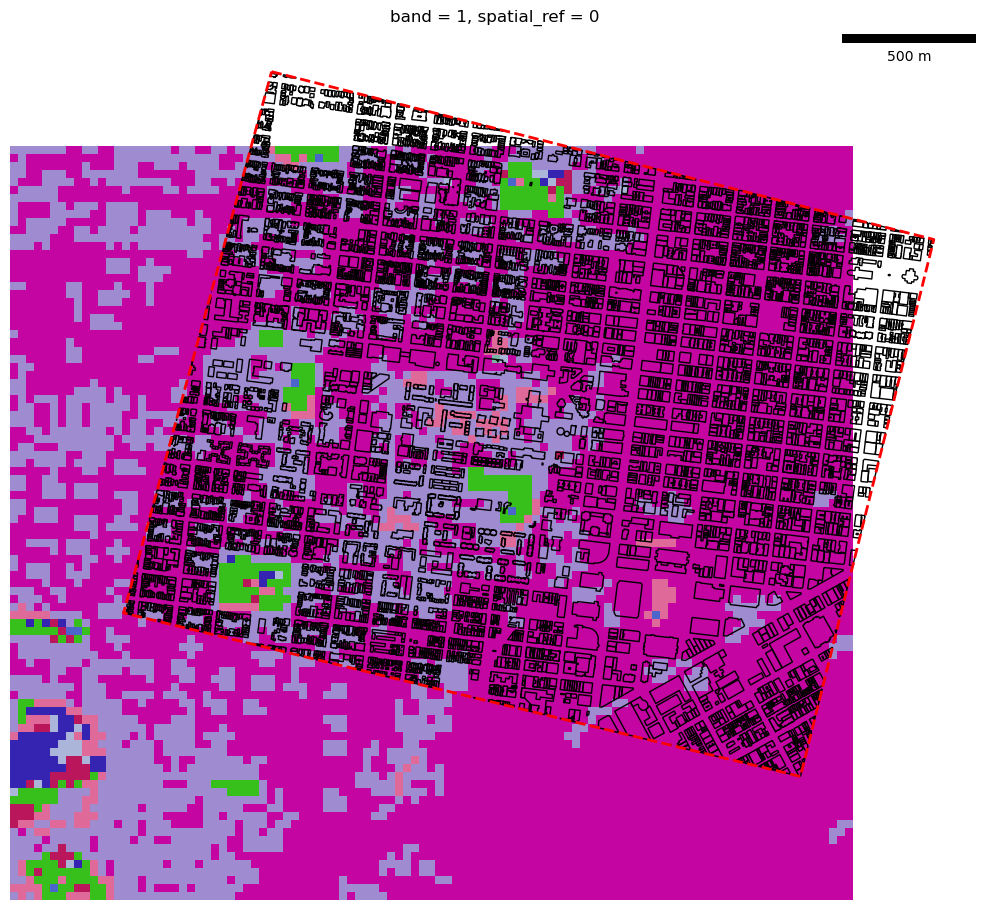

In [43]:
f, ax=plt.subplots(1,1,figsize=(10,10))
np.random.seed(10)
cmap=matplotlib.colors.ListedColormap (np.random.rand ( 256,3))
lulc.plot.imshow(ax=ax,add_colorbar=False,cmap=cmap)
building_footprints.plot(color='none',edgecolor='k',linewidth=1,ax=ax,linestyle='-')
aoi.plot(color='none',edgecolor='r',linewidth=2,ax=ax,linestyle='--')

ax.add_artist(ScaleBar(1))  
ax.set_axis_off()
plt.tight_layout()
plt.show()

查看对应 LULC 类型的生物物理表，包括对应栅格单元的遮荫指数（`Shade`列）、作物系数（`Kc`列）、反照系数（`Albedo`列）、绿地面积（`Green_aea`列）和建筑强度（`building_intensity`列）。

In [32]:
biophysical_UHI_fake=pd.read_csv(args['biophysical_table_path'])
biophysical_UHI_fake

,lucode,Description,Shade,Kc,Albedo,Green_area,building_intensity
0,0,Background,0.00,0.00,0.00,0,0.00
1,1,"Unclassified (Cloud, Shadow, etc)",0.00,0.00,0.00,0,0.00
2,2,High intens (>80% IA),0.05,0.37,0.18,0,0.95
3,3,Med intens (50-80%),0.18,0.55,0.19,0,0.30
4,4,Low intens (20-50%),0.33,0.76,0.19,0,0.10
5,5,Open space (<20%),0.45,0.93,0.20,0,0.10
6,6,Cultivated Land,1.00,0.70,0.20,1,0.00
7,7,Pasture/Hay,1.00,1.00,0.20,1,0.00
8,8,Grassland,1.00,1.00,0.20,1,0.00
9,9,Deciduous Forest,1.00,1.00,0.15,1,0.00


查看能源消耗表（Energy Consumption Table）。`Type`对应建筑轮廓数据`building_footprints`中的`Type`列。`Consumption`列为该类型建筑按占地面积计算的能源消耗，单位为 kWh/(m² · °C)。

> 建筑轮廓数据来源于[Open street map](https://www.openstreetmap.org/#map=3/9.45/59.06)<sup>⑥</sup>。

In [33]:
Fake_energy_savings=pd.read_csv(args['energy_consumption_table_path'])
Fake_energy_savings

,Type,Consumption
0,0,10


In [39]:
print(building_footprints.Type.unique())
building_footprints.head(3)

[0]


,fid,OBJECTID,highway,building,natural,waterway,amenity,landuse,place,railway,...,osmuid,osmvisible,osmversion,osmchanges,osmtimesta,osmSupport,SHAPE_Leng,SHAPE_Area,Type,geometry
0,211715.0,211721,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,...,1829683,true,1,20641189,2014-02-18,no,0.000813,2.102509e-08,0,"POLYGON ((inf inf, inf inf, inf inf, inf inf, ..."
1,211718.0,211724,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,...,1829683,true,1,20641189,2014-02-18,no,0.000565,1.339055e-08,0,"POLYGON ((inf inf, inf inf, inf inf, inf inf, ..."
2,209128.0,209134,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,...,1829683,true,1,20581073,2014-02-15,no,0.001721,9.632801e-08,0,"POLYGON ((inf inf, inf inf, inf inf, inf inf, ..."


调用城市降温模型并计算。

In [6]:
usda_esv.Urban_cooling(args);

查看城市热缓解指数计算结果。

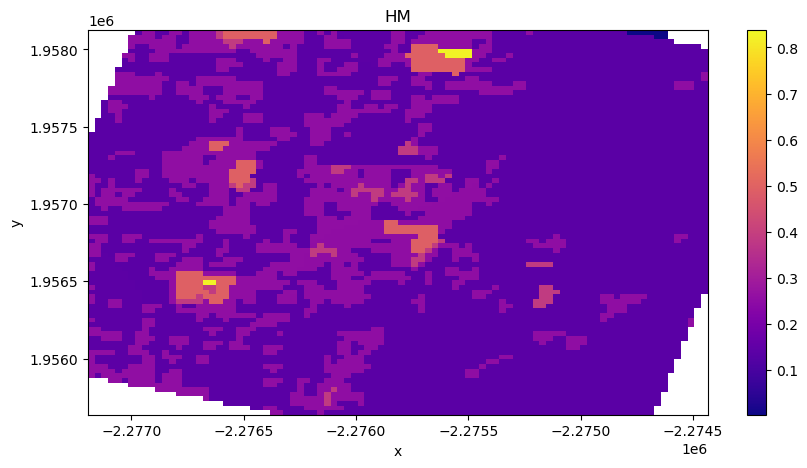

In [21]:
HM=rxr.open_rasterio(os.path.join(args['workspace_dir'],'hm.tif'),masked=True).squeeze()

f, ax=plt.subplots(1,1,figsize=(10,5))
cmap='plasma'
HM.plot.imshow(ax=ax,add_colorbar=True,cmap=cmap)
ax.set_title('HM')
plt.show()

查看分析区域`aoi`内统计结果。`avg_cc`列为平均 CC 值（无单位）；`uhi_results`列为平均温度值（$^\circ $）；`avg_tmp_an`列为平均异常温度（$^\circ $）；`avd_eng_cn`列为可避免的能源消耗（kWh或\$）；`avg_wbgt_v`列为平均湿球温度（综合温度热指数）（Wet Bulb Globe Temperature，WBGT）（$^\circ $）；`avg_ltls_v`列为轻作业（“light work” ）的工作效率损失（%）；`avg_hvls_v`列为重作业（“heavy work” ）的工作效率损失（%）。

In [23]:
uhi_results=gpd.read_file(os.path.join(args['workspace_dir'],'uhi_results.shp'))
uhi_results

,id,avg_cc,avg_tmp_v,avg_tmp_an,avd_eng_cn,avg_wbgt_v,avg_ltls_v,avg_hvls_v,geometry
0,0,0.180753,24.376901,2.876901,1.284465e+07,21.34953,0.0,0.0,"POLYGON ((-2276616.745 1958376.373, -2274139.8..."


查看建筑类统计结果，其中`energy_sav`列为能源节约价值（kWh）；`mean_t_air`列为建筑物的平均温度值（$^\circ $）。

In [30]:
buildings_with_stats=gpd.read_file(os.path.join(args['workspace_dir'],'buildings_with_stats.shp'))
buildings_with_stats[['fid','Type','energy_sav','mean_t_air']].head()

,fid,Type,energy_sav,mean_t_air
0,211715.0,0,225.276983,24.357432
1,211718.0,0,53.697835,24.357330
2,209128.0,0,3641.778178,24.357735
3,211726.0,0,1237.248379,24.357395
4,211720.0,0,1336.619844,24.357534


### 3.5.3.2 MRF 估计 LULC 类型转换对降温的作用

如果考虑通过置换 LULC 类型（并且尽可能使得栅格单元的近邻单元为同一类覆盖类型）实现降温的作用，可以建立 MRF 模型计算哪些单元具有置换的潜力，及具体置换的类型和观测区域 CC指数、平均温度等最大可以调控的值，或趋于某一指定值 LULC 类型参考置换方案等问题。下述试验的问题是，是否通过 LULC 类型置换使得观测区域平均温度能够降低$2 ^\circ C$，如果不能，最大可以降低多少，及给出 LULC 调控方案。

定义类`MRF_urban_cooling`实现 MRF 模型估计 LULC 类型转换对降温的作用，其节点位势为城市降温模型计算给定区域统计结果中的一项，本次试验选择了平均温度值，即`uhi_results`列值；边位势同前文*图像分割*部分，使用8-邻域系统，通过判断目标栅格单元和近邻栅格单元是否为同一分类来刻画邻接偏好。因为城市降温模型中间过程数据存储于本地磁盘，且需要不断更新，而 MRF 模型计算量随节点数量（LULC 栅格大小）和节点值域（LULC 类型，离散型）数量的增加成指数增加，因此完成该计算较耗时间。

因为城市降温模型仅计算平均温度，因此配置`do_energy_valuation`和`do_productivity_valuation`参数为`False`，不计算节能评估和工作生产力评估。

In [ ]:
muc=usda_pgm.MRF_urban_cooling(args,usda_esv.Urban_cooling,alpha=1,beta=1)

打印原始和更新后的 LULC 地图，并分别用`.`和`x`标识对降温有作用的栅格单元。从结果可以观察到，通常栅格单元转化为邻近栅格单元所属的土地利用类型，满足边位势配置的目的；且平均温度的下降说明，结果满足顶点位势配置的目的。

In [68]:
lulc=rxr.open_rasterio(args['lulc_raster_path'],masked=True).squeeze()
X=rxr.open_rasterio(r'I:\ESVs\urban_cooling_all\X.tif').squeeze()

classi_changed=lulc!=X
classi_changed_idx=np.stack(np.where(classi_changed==True),axis=1)

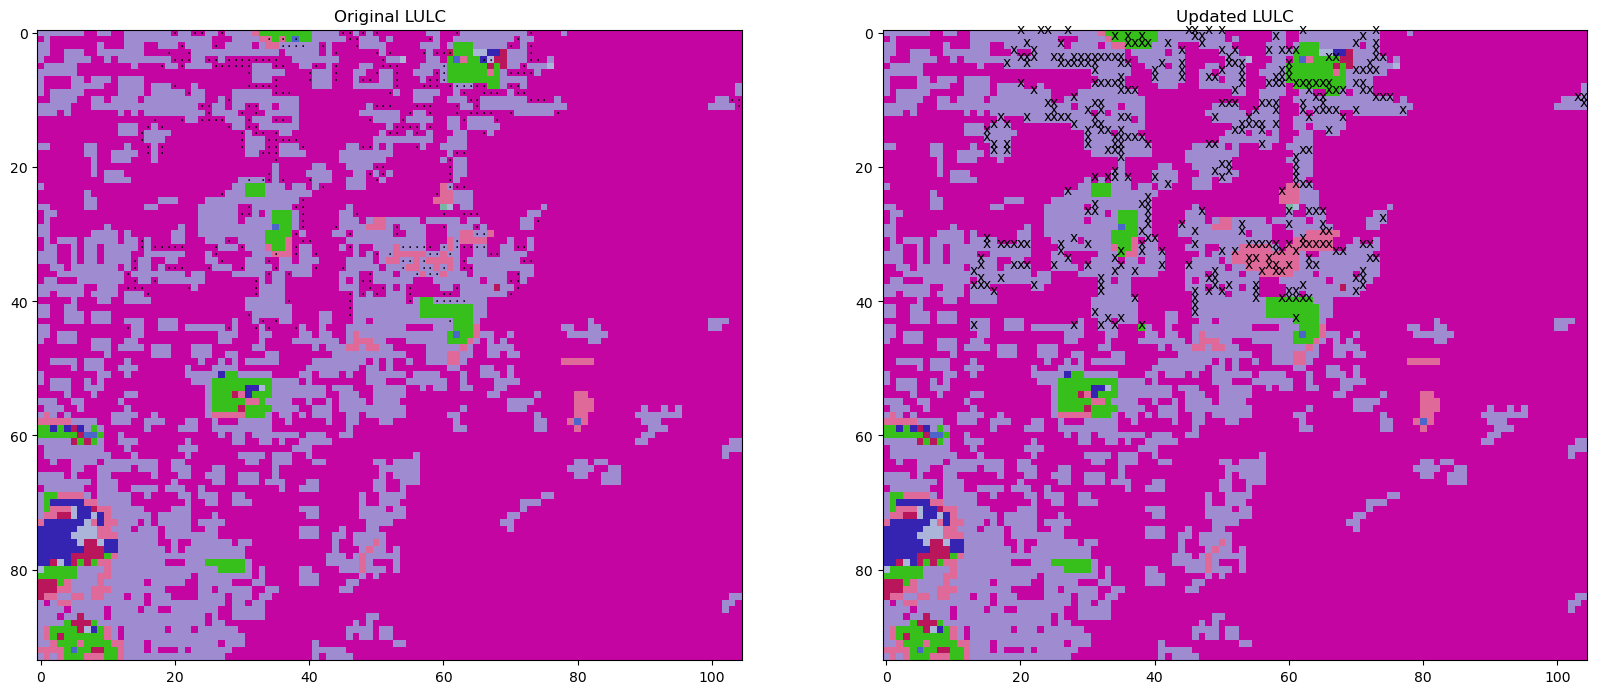

In [157]:
fig, axes=plt.subplots(1, 2,figsize=(20,10))
axes[0].imshow(lulc,cmap=cmap)
axes[1].imshow(X,cmap=cmap)

for idx in np.flip(classi_changed_idx,1):
    axes[0].annotate(text='.', xy=idx, horizontalalignment='center')
    axes[1].annotate(text='x', xy=idx, horizontalalignment='center')

axes[0].set_title('Original LULC')
axes[1].set_title('Updated LULC')
plt.show()

LULC 数据可以从[美国国家航空航天局（NASA）](https://lpdaac.usgs.gov/products/mcd12q1v006/)<sup>⑦</sup>（可以查看*MCD12Q1_v006 土地覆盖类型数据集*部分章节）或[欧洲航天局（European Space Agency）](https://esa-worldcover.org/en/data-access)<sup>⑧</sup>，[美国地质调查局（USGS）](https://www.usgs.gov/centers/eros/science/national-land-cover-database)<sup>⑨</sup>等数据源下载。实验用数据有18个分类，所分析区域仅含有7类。如下表<sup>[12]</sup>，

| lucode  | Land Use /Land Cover  | 中文  |
|---|---|---|
| 1  | Evergreen Needleleaf Forest  | 常绿针叶林  |
| 2  | Evergreen Broadleaf Forest  |  常绿阔叶林 |
| 3  | Deciduous Needleleaf Forest  |落叶针叶林   |
| 4  | Deciduous Broadleaf Forest  | 落叶阔叶林  |
| 5  | Mixed Cover  | 混交覆盖  |
| 6  | Woodland  | 林地  |
| 7  |  Wooded Grassland | 树木繁茂的草原  |
| 8  | Closed Shrubland  | 封闭灌木丛  |
| 9  | Open Shrubland  |  开阔灌木丛 |
| 10  | Grassland  | 草原  |
| 11  | Cropland (row Crops)  | 耕地（行栽作物）  |
| 12  | Bare Ground  | 裸地  |
|  13 |Urban and Built-Up   | 城市和建成区  |
| 14  | Wetland  | 湿地  |
| 15 | Mixed evergreen  | 混交常绿  |
| 16 | Mixed Forest  | 混交林  |
|17  | Orchards/Vineyards  |果园 /葡萄园   |
| 18 | Pasture  | 牧草地  |

为了观察 LULC 类型变化情况，将原始 LULC 到以降温为目的的 LULC 更新的映射转化为二部图表达和可视化，查看映射关系。将 LULC 类型作为顶点，将映射关系作为边，将映射关系的数量统计作为边的属性。

In [122]:
lulc_mapping=np.stack([lulc.values[classi_changed],X.values[classi_changed]],axis=1)

lulc_mapping_df=pd.DataFrame(lulc_mapping,columns=['original','target'])
lulc_mapping_df['original']=lulc_mapping_df.original.apply(lambda row:f'o_{int(row)}')
lulc_mapping_df['target']=lulc_mapping_df.target.apply(lambda row:f't_{int(row)}')
lulc_mapping_df.head(3)

,original,target
0,o_2,t_3
1,o_2,t_3
2,o_2,t_3


统计映射关系的数量，并作为图中边的属性。

In [137]:
o_t_counts=lulc_mapping_df.value_counts(['original','target'])
o_t_counts

original  target
o_2       t_3       311
o_3       t_4        26
          t_5        16
o_2       t_5         6
          t_4         3
o_4       t_5         3
o_3       t_2         2
o_10      t_5         1
o_11      t_5         1
o_12      t_5         1
o_8       t_5         1
Name: count, dtype: int64

建立二部图。

In [148]:
from networkx.algorithms import bipartite
import networkx as nx

B=nx.Graph()
B.add_nodes_from(lulc_mapping_df['original'], bipartite=0)
B.add_nodes_from(lulc_mapping_df['target'], bipartite=1)
B.add_edges_from(lulc_mapping_df.values)
nx.set_edge_attributes(B,{k:{'count':v} for k,v in o_t_counts.to_dict().items()})

打印 LULC 映射关系二部图。

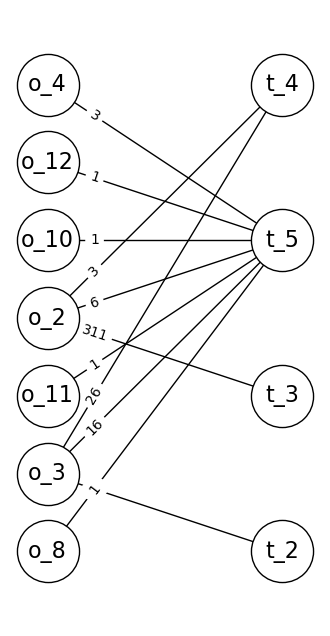

In [156]:
fig,ax=plt.subplots(figsize=(4,8))

options = {
    "font_size": 16,
    "node_size": 2000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}

top = nx.bipartite.sets(B)[0]
pos = nx.bipartite_layout(B, top)
nx.draw_networkx(B,pos=pos,ax=ax,**options)
nx.draw_networkx_edge_labels(B,pos=pos,edge_labels=o_t_counts.to_dict(), label_pos=0.8)

ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

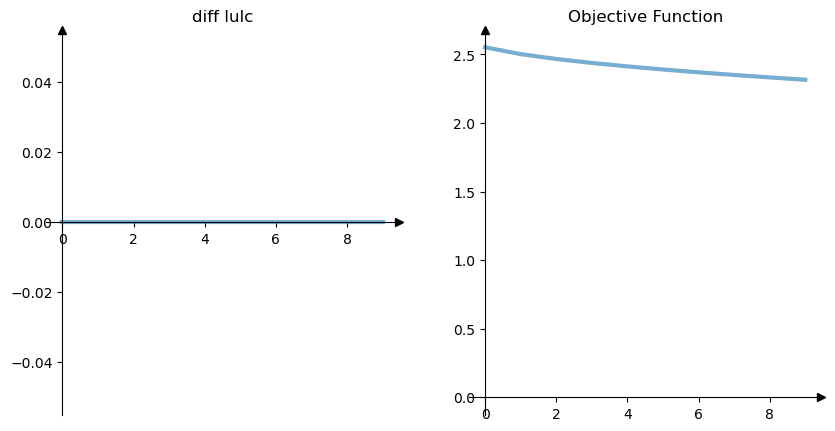

In [57]:
fig, axes=plt.subplots(1, 2,figsize=(10,5))

diff_lulc_detach=[i.detach().cpu().numpy() for i in muc.diff_lulc]
axes[0].plot(np.arange(0,len(diff_lulc_detach)),diff_lulc_detach, lw=3, alpha=0.6)
axes[1].plot(np.arange(0,len(muc.losses)),muc.losses, lw=3, alpha=0.6)

axes[0].set_title('diff lulc')
axes[1].set_title('Objective Function')

usda_vis.plot_style_axis_A(axes[0])
usda_vis.plot_style_axis_A(axes[1])
plt.show()

---

注释（Notes）：

① pgmpy库，（<https://github.com/pgmpy/pgmpy>）。

② Image Creator，（<https://www.bing.com/images/create>）。

③ 城市降温模型（Urban Cooling Model），（<https://storage.googleapis.com/releases.naturalcapitalproject.org/invest-userguide/latest/en/urban_cooling_model.html>）。

④ 全球地表热岛探测器（Global Surface UHI Explorer），（<https://yceo.users.earthengine.app/view/uhimap>）。

⑤ InVEST 模型 Python 库版本，（<https://invest.readthedocs.io/en/latest/index.html>）。

⑥ Open street map，（<https://www.openstreetmap.org/#map=3/9.45/59.06>）。

⑦ 美国国家航空航天局（NASA），（<https://lpdaac.usgs.gov/products/mcd12q1v006/>）。

⑧ 欧洲航天局（European Space Agency），（<https://esa-worldcover.org/en/data-access>）。

⑨ 美国地质调查局（USGS），（<https://www.usgs.gov/centers/eros/science/national-land-cover-database>）。

参考文献（References）:

[1] oller D, Friedman N. Probabilistic Graphical Models : Principles and Techniques / Daphne Koller and Nir Friedman. MIT Press; 2009.（[美]Daphne Koller [以色列]Nir Friedman 著, 王飞跃、韩素青 译出版社:清华大学出版社出版时间:2015.03）

[2] Ankan A, Panda A. Mastering Probabilistic Graphical Models Using Python : Master Probabilistic Graphical Models by Learning through Real-World Problems and Illustrative Code Examples in Python / Ankur Ankan, Abinash Panda. 1st edition. Packt Publishing; 2015.

[3] S.Z. Li, Markov Random Field Modeling in Image Analysis, 21 Advances in Pattern Recognition, DOI: 10.1007/978-1-84800-279-1 2, ©Springer-Verlag London Limited 2009

[4] Ankan, A., & Panda, A. (2015). pgmpy: Probabilistic graphical models using python. Proceedings of the 14th Python in Science Conference (SCIPY 2015). Citeseer.

[5] The Markov Random Field for Image Denoising - JMA, <https://www.kaggle.com/code/ukveteran/the-markov-random-field-for-image-denoising-jma/notebook>.

[6] Markov Random Fields, W.G.H.S. Weligampola (E/14/379),June 2020,<https://www.cs.umd.edu/~gihan/resources/em509/>.

[7] Image Denoising with Markov Random Fields, <https://www.safwan.xyz/2020/04/20/mrf_denoising.html>.

[8] Estimating the cooling capacity of green infrastructures to support urban planning

[9] Kunapo, J., Fletcher, T. D., Ladson, A. R., Cunningham, L., & Burns, M. J. (2018). A spatially explicit framework for climate adaptation. Urban Water Journal, 15(2), 159-166. https://doi.org/10.1080/1573062X.2018.1424216

[10] Phelan, P. E., Kaloush, K., Miner, M., Golden, J., Phelan, B., Silva, H., & Taylor, R. A. (2015). Urban Heat Island: Mechanisms, Implications, and Possible Remedies. Annual Review of Environment and Resources, 40(1), 285–307. doi:10.1146/annurev-environ-102014-021155

[11] Zawadzka, J. E., Harris, J. A. & Corstanje, R. Assessment of heat mitigation capacity of urban greenspaces with the use of InVEST urban cooling model, verified with day-time land surface temperature data. Landsc Urban Plan 214, 104163 (2021).

[12] InVEST Data Sources, <https://storage.googleapis.com/releases.naturalcapitalproject.org/invest-userguide/latest/en/data_sources.html#lulc>.